# Homework 28

Section 6.3

Logan Schelly

Math 402

Fall 2019

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm

### Exercise 6.12
Load the dataset Housing.csv (the training set from [https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)) with a description of the data in Housing_data_description.txt.  

In [2]:
hdf = pd.read_csv('./hw63_data/train.csv')

The goal is to construct a regression model that predicts ``y = SalePrice`` using other features of the dataset.  Do this as follows:

### Part (i)
Identify and handle the missing data.  Hint: Dropping every row with some missing data is not a good choice because it gives you an empty dataframe.  What can you do instead?


In [3]:
#Let's first look at the dataframe.
hdf

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4            Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
...          ...       ...  ...      ...    ...    ...         ...     ...   
1455         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1456         Lvl    AllPub  ...        0    NaN  MnPrv         NaN       0   
1457         Lvl    AllPub  ...        0    NaN  GdPrv        Shed    2500   
1458         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1459         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
0         2   2008        WD         Normal     208500  
1         5   2007        WD         Normal     181500  
2         9   2008        WD         Normal     223500  
3         2   2006        WD        Abnorml     140000  
4        12   2008        WD         Normal     250000  
...     ...    ...       ...            ...        ...  
1455      8   2007        WD         Normal     175000  
1456      2   2010        WD         Normal     210000  
1457      5   2010        WD         Normal     266500  
1458      4   2010        WD         Normal     142125  
1459      6   2008        WD         Normal     147500  

[1460 rows x 81 columns]

In [4]:
#That id column is stupid, so let's drop it
hdf.drop(columns='Id', inplace=True)

#Now, let's look at the columns that have the most missing values.
x = hdf.isna().sum(axis=0)
x = x[x>0]
x

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

##### Columns to drop:
* LotFrontage -- It should be a numerical value.  Not an easy way to fix this, and several properties are missing it.

##### Rows to drop:
* The row where BsmtExposure is N/A, indicating there isn't a basement, but BsmntQual is not N/A (afterwards, I'll check to see if they're all 37)
* The one row with no electrical data.

##### To keep, and deal with while cleaning later:
For all of theses columns, NaN indicates the feature isn't present.  So, these should probably be changed to categorical later on, or dropped because they're not useful features.  At the moment, however, NaN is a perfectly acceptable value.
* Alley
* MasVnrType
* MasVnrArea
* BsmtQual
* BsmtCond
* BsmtExposure
* BsmtFinType1
* BsmtFinType2
* GarageType
* GarageYrBlt
* GarageFinish
* GarageQual
* GarageCond
* PoolQC
* Fence
* MiscFeature

In [5]:
hdf.drop(columns='LotFrontage', inplace=True)

#Find the indices where electric was all weird, and the one weird basement entry.
indicesToDrop = hdf[hdf.Electrical.isna() |
                    (~hdf.BsmtQual.isna() & hdf.BsmtExposure.isna())].index
hdf.drop(indicesToDrop, inplace=True)

#Check for the weird basement case.
basement_features = ["BsmtQual", "BsmtCond", "BsmtFinType1", "BsmtFinType2"]
hdf.loc[:, basement_features].isna().sum(axis=0)

BsmtQual        37
BsmtCond        37
BsmtFinType1    37
BsmtFinType2    38
dtype: int64

In [6]:
#Ok, we'll also want to get the wacko row with BsmtFinType2.
indicesToDrop = hdf[hdf.Electrical.isna() |
                    (~hdf.BsmtQual.isna() & hdf.BsmtFinType2.isna())].index
hdf.drop(indicesToDrop, inplace=True)

hdf.loc[:,basement_features].isna().sum(axis=0)

BsmtQual        37
BsmtCond        37
BsmtFinType1    37
BsmtFinType2    37
dtype: int64

### Part (ii)
Identify variables that have nonnumeric values that are misencoded as numbers:

##### Misencoded as numbers:
* MSSubClass
* OverallQual
* OverallCond

### Part (ii) continued
For each such variable
    
    a) Delete the column if it has no value to the model.
    b) Recode it as strings if you think it might be useful (in an abstract way, for example by a human trying to estimate the sale price).
    c) One-hot encode it if you think it might be useful in a regression model.  Hint: don't forget to remove one of the encoded columns to prevent collinearity with the constant column (which you will add later).
    d) Justify your choice of whether to delete, one-hot encode, or convert to strings.
    
##### MSSubClass
I'm going to delete this column.  I don't think it tells you anything you can't get from  ``BldgType``, ``HouseStyle``, and ``YearBuilt``.  I recognize that it might be a good 'executive summary' feaure and some people might want to encode it as a string.  I'm just going to choose not to, since we have so many features already.

##### OverallQual and OverallCond
These are human-made rankings, and so they might not be exactly linear (I doubt a house with overall quality of 10 will sell for 5 times the value of a house with overall quality 2).  I still think that these features are useful, however, so I think they should be one-hot encoded.

In [7]:
#Drop
hdf.drop(columns = 'MSSubClass', inplace=True)

#One-hot-encode
target_columns = ["OverallQual", "OverallCond"]
scores = pd.get_dummies(hdf.loc[:,target_columns], columns=target_columns, drop_first=True)
#Insert them between 'OverallQual' and 'OverallCond'
hdf = pd.concat([hdf.loc[:,:'OverallQual'], scores, hdf.loc[:,'OverallCond':]]
               , axis=1)
#Drop the target columns.
hdf.drop(columns = target_columns, inplace=True)

### Part (iii)
Identify and one-hot encode any nonnumerical categorical variables that need to be included in the regression model and delete any categorical variables that you do not think need to be included.  Justify your choice of which to encode and which to delete.  Hint: don't forget to remove one of the one-hot-encoded columns for each categorical variable.

##### Identify the categorical variables:

In [8]:
categorical_cols = hdf.select_dtypes(object).columns

#Let's look at the counts of each of these categorical things.
for col in categorical_cols:
    print(col)
    print(hdf.loc[:, col].value_counts(dropna=False))
    print()
    

MSZoning
RL         1148
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

Street
Pave    1451
Grvl       6
Name: Street, dtype: int64

Alley
NaN     1366
Grvl      50
Pave      41
Name: Alley, dtype: int64

LotShape
Reg    924
IR1    482
IR2     41
IR3     10
Name: LotShape, dtype: int64

LandContour
Lvl    1308
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

Utilities
AllPub    1456
NoSeWa       1
Name: Utilities, dtype: int64

LotConfig
Inside     1049
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

LandSlope
Gtl    1379
Mod      65
Sev      13
Name: LandSlope, dtype: int64

Neighborhood
NAmes      225
CollgCr    149
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     76
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
IDOTRR      37
Timber      37
ClearCr     28
SWISU       25
StoneBr     25
Meado

##### MSZoning
Keep. This seems like a good one.  We have a decent spread across the categories, and I would expect more low-density housing to be favorable to people who like their space.
###### Street
Drop.  We only have 6 gravel samples.  I don't think that's enough data to reliably extrapolate from.
##### Alley
Drop. Maybe I don't understand this feature well enough, but I don't see how this would add value to a home.  I don't expect you would have ONLY alley access.
##### LotShape
Drop. Not sure why this would matter, unless it is like a horribly misshapen lot.  I doubt LotShapes get so terrible that it affects whether or not you want to live there.
###### LandCountour
Keep. Hillside might give a good view.
##### Utilities
Drop. Not enough variety in samples to reliably regress. (only 1 without sewage, all others have all utilities)
##### LotConfig
Keep. Might affect street noise.  I'll keep and encode this.
##### LandSlope
Drop.  Already have LandContour.
##### Neighborhood
Keep. Huge correlation between neighboring house prices.
##### Condition1 and Condition2
Keep.  Make 'Norm' the default.  This capture nearness to inconvenient things like busy streets and railroads.  Also captures nearness to parks.
##### BldgType
Keep.  It determines whether you share a wall with a neighbor.
##### House Style
Keep.  Second floors are cool.
##### RoofStyle
Drop.  I don't think it affects the price that much.
##### RoofMatl
Drop.  Not enough samples that aren't CompShg
##### Exterior1st and Exterior2nd
Drop.  Might slightly affect price, but I think it's just getting too detailed.
##### MasVnrType
Drop.  Too much detail.  (That means we should probably also drop MasVnrArea).
##### ExterQual
Keep.  Too big picture to throw away.
##### ExterCond
Keep.  Again, too big picture to throw away.
##### Foundation
Drop.  Too much detail.
##### BsmtQual
Keep. Gives the height of the basement.  I don't like stooping.
##### BsmtCond
Keep.  Big picture.
##### BsmtExposure
Drop.  Just seems like overkill.
##### BsmtFinType1, BsmtFinType2
Keep.  Just because I want to see how to combine this together.
##### Heating
Drop.  Next feature seems like it covers this better.
##### HeatingQC
Drop.  Nobody likes a really cold house, but the cost of fixing this is probably small in comparison to the house.
##### CentralAir
Drop.  Similar reasons to HeatingQC.
##### Electrical
Drop.  Seems like too much detail.
##### KitchenQual
Drop.  Seems like a good indicator, but I want to keep the model a bit more simple.
##### Functional
Drop.  No idea what this means.
##### FireplaceQu
Drop.  Too much detail.
##### GarageType, GarageQual, GarageCond
Keep.  Garages add value.
##### GarageFinish
Drop.  GarageQual probably is more predictive.
##### PavedDrive
Drop.  Seems not as important.
##### PoolQC
Drop. There are only 7 non-null entries.
##### Fence
Drop. I wouldn't expect it to affect value as much.
##### MiscFeature
Drop. Only 5 of the ones recorded weren't sheds.  Sheds don't seem that valuable compared to a house.
##### SaleType
Keep.  Condition of sale can affect price of the exact same house.
##### SaleCondition
Keep.  Same reason.


In [9]:
#Drop the columns that don't seem to add much.
to_drop = ['Street', 'Alley', 'LotShape', 'Utilities',
           'LandSlope', 'RoofStyle', 'RoofMatl',
           'Exterior1st', 'Exterior2nd', 'MasVnrType',
           'Foundation', 'BsmtExposure', 'Heating',
           'HeatingQC', 'CentralAir', 'Electrical',
           'KitchenQual', 'Functional', 'FireplaceQu',
           'GarageFinish', 'PavedDrive', 'PoolQC',
           'Fence', 'MiscFeature']
hdf.drop(columns=to_drop, inplace=True)

#Decide which feature will be the default in encoding.
default = {
    "MSZoning":"RL",
    "LandContour":"Lvl",
    "LotConfig":"Inside",
    "Neighborhood":"NAmes",
    "BldgType":'1Fam',
    "HouseStyle":"1Story",
    "ExterQual":"TA",#Remember to include a column for Po
    "ExterCond":"TA",
    "BsmtQual":None,
    "BsmtCond":None,
    "GarageType":None,
    "GarageQual":None,
    "GarageCond":None,
    "SaleType":"WD",
    "SaleCondition":"Normal"
}

for col in default.keys():
    
    encoded = pd.get_dummies(hdf.loc[:,col], prefix=col)#Fun fact: by default get_dummies does not encode a NaN column.
    if default[col] is not None:
        encoded.drop(columns=col+'_'+default[col], inplace=True)
    
    i = hdf.columns.get_loc(col)
    hdf = pd.concat([hdf.iloc[:,:i], encoded, hdf.iloc[:,i:]], axis=1)
    hdf.drop(columns=col, inplace=True)
    
#Now deal with Condition1 and Condition2
encoded1 = pd.get_dummies(hdf.loc[:,'Condition1']).drop(columns='Norm')
encoded2 = pd.get_dummies(hdf.loc[:,'Condition2']).drop(columns='Norm')
encoded = encoded1 + encoded2
encoded.fillna(0, inplace=True) #RRNe doesn't have anything happen.
hdf = pd.concat([hdf.loc[:, :'Condition1'], encoded, hdf.loc[:,'Condition2':]], axis=1)
hdf.drop(columns=["Condition1", "Condition2"], inplace=True)
encoded

Artery  Feedr  PosA  PosN  RRAe  RRAn  RRNe  RRNn
0          0      0     0     0     0     0   0.0     0
1          0      1     0     0     0     0   0.0     0
2          0      0     0     0     0     0   0.0     0
3          0      0     0     0     0     0   0.0     0
4          0      0     0     0     0     0   0.0     0
...      ...    ...   ...   ...   ...   ...   ...   ...
1455       0      0     0     0     0     0   0.0     0
1456       0      0     0     0     0     0   0.0     0
1457       0      0     0     0     0     0   0.0     0
1458       0      0     0     0     0     0   0.0     0
1459       0      0     0     0     0     0   0.0     0

[1457 rows x 8 columns]

In [10]:
#Want to combine BsmtFinType2 and BsmtFinType1 with BsmtFinSF1 and BsmtFinSF2 into one, in this clever way.
#Technically, I'm kind of doing part (v) here.
encoded1 = pd.get_dummies(hdf.BsmtFinType1, prefix='Bsmt', prefix_sep='')
encoded1 = encoded1.multiply(hdf.BsmtFinSF1,axis=0)
encoded2 = pd.get_dummies(hdf.BsmtFinType2, prefix='Bsmt', prefix_sep='')
encoded2 = encoded2.multiply(hdf.BsmtFinSF2, axis=0)
encoded = encoded1 + encoded2
print(encoded)

      BsmtALQ  BsmtBLQ  BsmtGLQ  BsmtLwQ  BsmtRec  BsmtUnf
0           0        0      706        0        0        0
1         978        0        0        0        0        0
2           0        0      486        0        0        0
3         216        0        0        0        0        0
4           0        0      655        0        0        0
...       ...      ...      ...      ...      ...      ...
1455        0        0        0        0        0        0
1456      790        0        0        0      163        0
1457        0        0      275        0        0        0
1458        0        0       49        0     1029        0
1459        0      830        0      290        0        0

[1457 rows x 6 columns]


In [11]:
#If we check, we'll see there are no entries in the unfinished column.
print(encoded.BsmtUnf[encoded.BsmtUnf>0])

Series([], Name: BsmtUnf, dtype: int64)


In [12]:
#Let's check the BsmtUnfSF column.
hdf.BsmtUnfSF[hdf.BsmtUnfSF > 0]

0       150
1       284
2       434
3       540
4       490
       ... 
1454    811
1455    953
1456    589
1457    877
1459    136
Name: BsmtUnfSF, Length: 1339, dtype: int64

In [13]:
#So, we can just drop the unfinished column in our encoding.
encoded.drop(columns=['BsmtUnf'], inplace=True)
#Also, I'd like to append 'SF' to the column names.
encoded.rename(columns = lambda x : x+'SF', inplace=True)
print(encoded)

      BsmtALQSF  BsmtBLQSF  BsmtGLQSF  BsmtLwQSF  BsmtRecSF
0             0          0        706          0          0
1           978          0          0          0          0
2             0          0        486          0          0
3           216          0          0          0          0
4             0          0        655          0          0
...         ...        ...        ...        ...        ...
1455          0          0          0          0          0
1456        790          0          0          0        163
1457          0          0        275          0          0
1458          0          0         49          0       1029
1459          0        830          0        290          0

[1457 rows x 5 columns]


In [14]:
#Insert this into the dataframe, and remove the columns we built it with.
hdf = pd.concat([hdf.loc[:, :'BsmtFinType1'], encoded, hdf.loc[:,'BsmtFinSF1':]], axis=1)
hdf.drop(columns=["BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2"], inplace=True)
#Check out how the columns compare.
hdf.loc[:, 'BsmtALQSF':'TotalBsmtSF']

BsmtALQSF  BsmtBLQSF  BsmtGLQSF  BsmtLwQSF  BsmtRecSF  BsmtUnfSF  \
0             0          0        706          0          0        150   
1           978          0          0          0          0        284   
2             0          0        486          0          0        434   
3           216          0          0          0          0        540   
4             0          0        655          0          0        490   
...         ...        ...        ...        ...        ...        ...   
1455          0          0          0          0          0        953   
1456        790          0          0          0        163        589   
1457          0          0        275          0          0        877   
1458          0          0         49          0       1029          0   
1459          0        830          0        290          0        136   

      TotalBsmtSF  
0             856  
1            1262  
2             920  
3             756  
4            1145  
...           ...  
1455          953  
1456         1542  
1457         1152  
1458         1078  
1459         1256  

[1457 rows x 7 columns]

In [15]:
#Check that TotalBsmtSF matches what we've got.
diff = hdf.TotalBsmtSF - hdf.loc[:,"BsmtALQSF":"BsmtUnfSF"].sum(axis=1)
diff[diff.abs()>0]

Series([], dtype: int64)

In [16]:
#The difference is zero in each row.
#This means we can drop the TotalBsmtSF column as well.  It also means the data is pretty consistent! Yay!
hdf.drop(columns='TotalBsmtSF', inplace=True)

### Part (iv)
For each continuous variable (not the encoded categorical variables), plot ``SalePrice`` as a function of that variable.
If the plot looks nonlinear, engineer an appropriate nonlinear feature to add to the dataframe (and give it a descriptive name).  Justify your choices.

In [17]:
continuous_variables = [
    "LotArea",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt",
    "GarageCars",
    "GarageArea",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "MoSold",
    "YrSold"
    ]

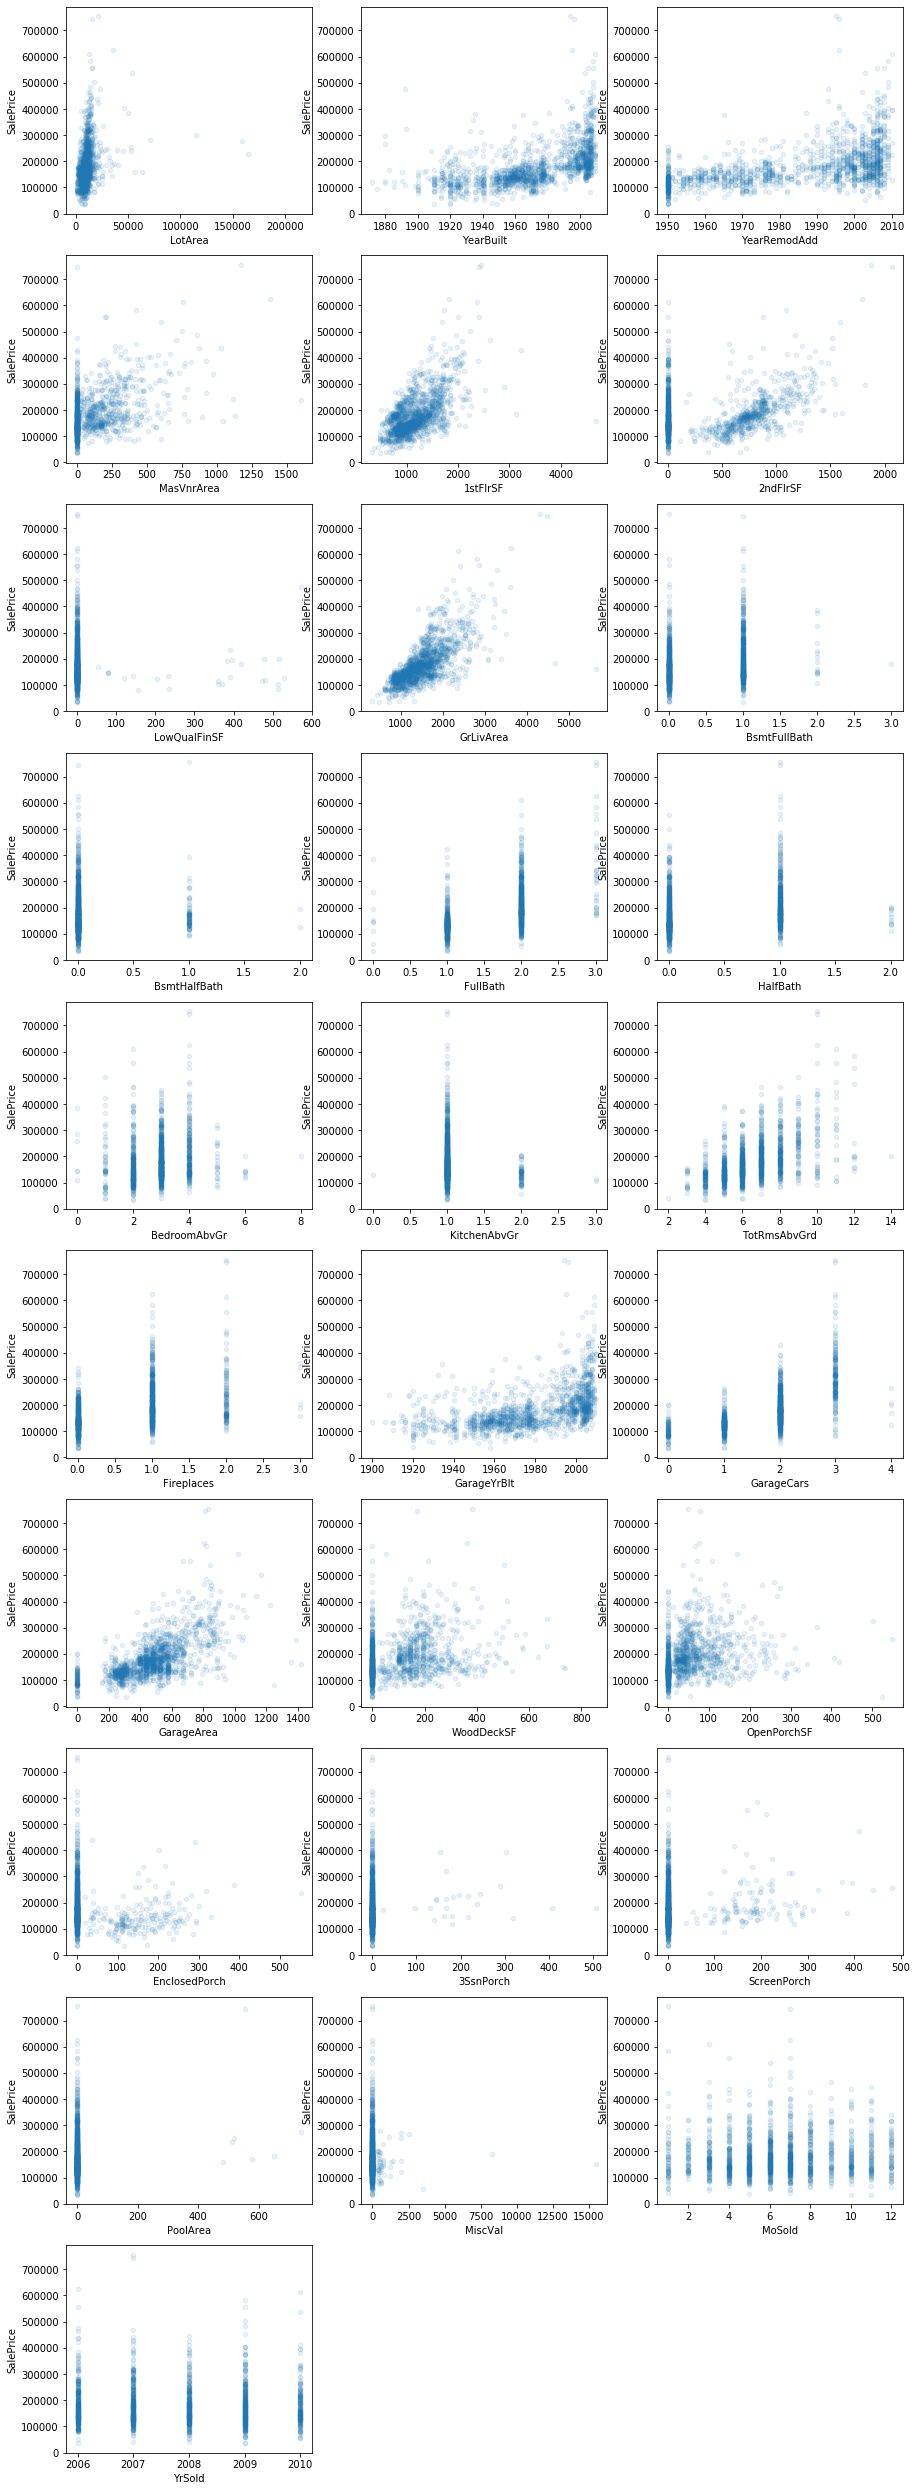

In [18]:
m, n = 10, 3
fig = plt.figure(figsize=(15, 45))
for i, var in enumerate(continuous_variables):
    ax = plt.subplot(m, n, i+1)
    hdf.plot(kind='scatter', x=var, y='SalePrice', alpha=.1, ax=ax)
plt.show()

Lot area got cut off by a couple outliers.  Let's trim the plot.

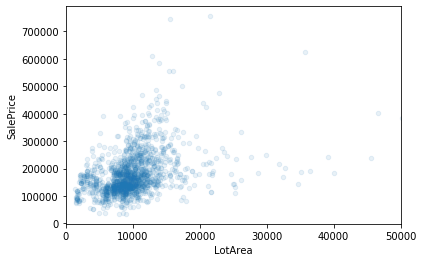

In [19]:
hdf.plot(kind='scatter', x='LotArea', y='SalePrice', xlim=[0, 50000], alpha=.1)
plt.show()

##### Engineering of nonlinear features.
If you check the plots for ``GarageYrBlt`` and ``YearBuilt``, they both seem to roughly resemble a shifted negative logarithm function.  So, I'll engineer a new feature that is the shifted and stretched logarithm of the age.

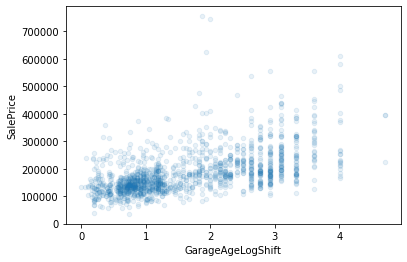

In [20]:
garage_age = hdf.GarageYrBlt.max() +1 - hdf.GarageYrBlt
garage_age_log = np.log(garage_age)
#Normalize it
garage_age_score = garage_age_log.max() - garage_age_log
hdf["GarageAgeLogShift"] = garage_age_score
house_age_log = np.log(hdf.YearBuilt.max() + 1 - hdf.YearBuilt) 
hdf["AgeLogShift"] = house_age_log.max() - house_age_log 
hdf.plot(kind='scatter', x="GarageAgeLogShift", y='SalePrice', alpha=.1)
plt.show()

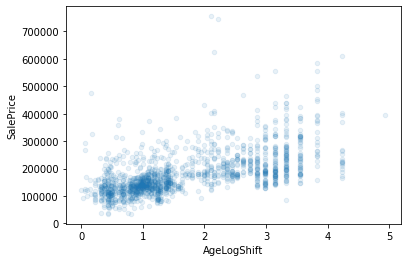

In [21]:
hdf.plot(kind='scatter', x='AgeLogShift', y='SalePrice', alpha=.1)
plt.show()

### Part (v)
Identify at least three pairs of features for which a cross-term of the form ``feature1 * feature2`` seems likely to be useful for a regression model and add the corresponding cross terms to the dataframe (with descriptive names.)

##### Work
If you look back at execution cells 10 through 16, you'll see that I've already engineered features of the form ``BsmntFinType1 * BsmntFinSF1`` and ``BsmntFinType2 * BsmntFinSF2`` to just give the total square feet of each type of basement classification.  I think one other feature worth putting would be ``GarageArea * GarageCond``.  Essentially, it would just give the square feet of the kind of garage condition.


In [22]:
product = hdf.loc[:, "GarageCond_Ex":"GarageCond_TA"].multiply(hdf.GarageArea, axis=0)
product.rename(columns = lambda x : x.replace('_', '') + 'SF', inplace=True)
hdf = pd.concat([hdf.loc[:,:"GarageCond_Ex"], product, hdf.loc[:,"GarageCond_TA":]], axis=1)
hdf.drop(columns=["GarageCond_Ex", "GarageCond_TA", "GarageArea"], inplace=True)

Additionally, ``GarageYearBlt`` and ``GarageAgeLog`` still have ``NaN``s in them.  To deal with this, we'll multiply them to ``GarageQual``.

In [23]:
product_year = hdf.loc[:, "GarageQual_Ex":"GarageQual_TA"].multiply(hdf.GarageYrBlt.fillna(0), axis=0)
product_year.rename(columns = lambda x : x.replace('_', '') + ' * Year', inplace=True)

product_log = hdf.loc[:, "GarageQual_Ex":"GarageQual_TA"].multiply(hdf.GarageAgeLogShift.fillna(0), axis=0)
product_log.rename(columns = lambda x: x.replace('_', "") + " * AgeLogShift", inplace=True)
hdf = pd.concat([hdf.loc[:,:"GarageQual_Ex"], product_year, hdf.loc[:,"GarageQual_TA":], product_log], axis=1)
hdf.drop(columns=["GarageQual_Ex", "GarageQual_TA", "GarageYrBlt", "GarageAgeLogShift"], inplace=True)

### Part (vi)
Add a constant column to the dataframe.

In [24]:
hdf["Constant"] = 1.0

In [25]:
hdf.Constant

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1455    1.0
1456    1.0
1457    1.0
1458    1.0
1459    1.0
Name: Constant, Length: 1457, dtype: float64

### Part (vii)
Run an OLS regression on your model.

In [26]:
#Before we do this, we should replace the NaNs in MasVnrArea with zeros.
hdf.MasVnrArea.fillna(0, inplace=True)

X = hdf.drop(columns='SalePrice')
y = hdf.SalePrice
results = sm.OLS(y, X).fit()

In [27]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     69.81
Date:                Sun, 10 Nov 2019   Prob (F-statistic):               0.00
Time:                        21:45:50   Log-Likelihood:                -16904.
No. Observations:                1457   AIC:                         3.411e+04
Df Residuals:                    1306   BIC:                         3.491e+04
Df Model:                         150                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
MSZoning_C (all)    

### Part (viii)
Pretend the model is identifiable (it almost surely is not) and interpret the meaning of the three largest positive coefficients and the three largest (in magnitude) negative coefficents.

In [28]:
#Show the beta coefficients sorted by value.
results.params.sort_values()

ExterCond_Po                  -54908.581834
GarageQualPo * AgeLogShift    -35835.257450
HouseStyle_2.5Fin             -31687.918375
GarageQualEx * AgeLogShift    -29469.514600
PosN                          -28091.363459
                                  ...      
GarageType_BuiltIn            496129.211836
GarageType_Detchd             497756.795810
GarageType_Attchd             498500.626475
GarageType_Basment            506162.768557
Constant                      702430.977070
Length: 154, dtype: float64

##### Three Most Positive Coefficients:
* ``Constant`` -- Starting value is \$702,430 and we start dinging points from there.
* ``GarageType_Basement`` -- Having a basement garage is pretty sweet, and also pretty costly. Adds $506,162 to the home value.
* ``GarageType_Attchd`` -- An attached garage is worth \$498,500

##### Three Most Negative Coefficients
* ``ExterCond_Po`` -- If the exterior condition of the house is poor, then deduct \$54,908 from the sale price.
* ``GarageQualPo * AgeLogShift`` -- The formula for AgeLogShift can roughly be thought of as $-\log(\text{age})$.  So, as age increases, AgeLogShift decreases.  This basically means that poor-quality garages get penalized less as they age.
* ``HouseStyle_2.5Fin`` -- Penalize \$31,687 for a 2.5 story house with a finished attic.
